# Data Science - Capstone Project

### Table of content
1. [Introduction](#intro)
2. [Data](#data)
3. [Methodology](#methods)
4. [Results](#methods)
5. [Discussion](#methods)
6. [Conclusion](#methods)

<a name="intro"></a>
## 1. Introduction/Business Problem
Despite the ongoing global turmoil caused by the spread of the novel coronavirus and the restrictions
of movement that people have to live with to contain the threat, it's safe to say that the people's desire
to travel to foreign countries and cities will be unbroken in the foreseeable future. Travel companies have a huge interest in getting the best possible information and process it in the best possible way to be able to offer their customers helpful and precise advice on their travel destinations. In the modern digital world with all its available information travellers are increasingly demanding and require easily accessible but comprehensive and precise information about their planned journey and destinations. One of the most common type of traveling is a business or non-business city trip, where a traveller is in need of quick orientation in an unknown metropolis with its overwhelming impressions, opportunities, venues and wide variety of unique districts with their individual characters. Wouldn't it be great to help travellers in providing them a useful clustering system for neighbourhoods of each individual city based on several dimensions of up-to-date information? In this project we'll try to offer a solution to this problem.


### importing the libraries:

In [293]:
import numpy as np # library to handle data in a vectorized manner
from bs4 import BeautifulSoup

import os
import math


# use module dotenv to manage API keys and secrets
%load_ext dotenv
%dotenv

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)

import json # library to handle JSON files
import re # library for regular expressions

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.geocoders import ArcGIS # convert an address into latitude and longitude values


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist


#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Libraries imported.


<a name="data"></a>
## 2. Data
To address our problem we will use data from http://insideairbnb.com/index.html, a website sourcing
publicly available information from the Airbnb site. This data includes listings of accomodations of more than hundred cities worldwide, along with geo data of the cities' neighbourhoods. We will use the price and room type information of the listings data along with venues information from the Foursquare API to build a meaningful and characteristic feature set for each neighbourhood of a specific city and then apply a K-Means model to gain clusters of similar city districts.

Data used in the project:  
1.) Airbnb data from http://insideairbnb.com/index.html:  
- `listings.csv` Summary information and metrics for listings in a specific city
- `neighbourhoods.csv`
- `neighbourhoods.geojson` GeoJSON file of neighbourhoods of the city, used for visualisations.
2.) Foursquare API to retrieve the venues for the neighbourhoods of a specific city.


### Downloading Airbnb data
First we'll define some helper functions for downloading data from insideairbnb.com with BeautifulSoup.
The files will be downoaded to a subfolder in the following folder path:  
+-- data  
|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; +-- airbnb  
|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;+--airbnb_*city_name* (e.g. "airbnb_brussels")

`download_airbnb_data` takes a specific city name as a parameter and and uses the BeautifulSoup library to download the current csv and geojson files into a city specific folder
in the above mentioned directory. `download_airbnb_data_list` takes a list of city names and executes `download_airbnb_data`for each of
the given cities separately.

In [ ]:
data_folder = "./data/airbnb"

def download_airbnb_data(city):
    url_airbnb = "http://insideairbnb.com/get-the-data.html"
    search = city.lower()
    print(search)
    website_url = requests.get(url_airbnb).text
    soup = BeautifulSoup(website_url,'html.parser')
    table = soup.find('table',{'class':search})
    city_folder = f"{data_folder}/airbnb_{search}"
    if (table):
        print(search + " found. Looking for files ...")
        try:
            os.mkdir(city_folder)
        except FileExistsError:
            print('Directory already exists, not created.')
    trs = table.find_all('tr', class_=lambda x: x != 'archived')
    for tr in trs:
        a = tr.find_all('a')
        for link in a:
            #print(link['href'])
            #print(re.search('csv$',link['href']))
            if (re.search('[(csv)|(geojson)]$',link['href'])):
                print("downloading: " + link['href'])
                r = requests.get(link['href'])
                #print(r)
                #print(link.text)
                with open(city_folder +'/' + (link.text).strip(), 'wb') as f:
                    f.write(r.content)

def download_airbnb_data_list(cities):
    for city in cities:
        download_airbnb_data(city)
    print("download done")

#### Downloading data for London
We will use the city of London as an example for the complete workflow. So let's download the data:

In [363]:
cities = ['London']
download_airbnb_data_list(cities)

london
london found. Looking for files ...
Directory already exists, not created.
downloading: http://data.insideairbnb.com/united-kingdom/england/london/2020-03-15/visualisations/listings.csv
downloading: http://data.insideairbnb.com/united-kingdom/england/london/2020-03-15/visualisations/reviews.csv
downloading: http://data.insideairbnb.com/united-kingdom/england/london/2020-03-15/visualisations/neighbourhoods.csv
downloading: http://data.insideairbnb.com/united-kingdom/england/london/2020-03-15/visualisations/neighbourhoods.geojson
download done


### Creating the data frames
Next we will create the data frames we will work with in the further stages of the project. To this end we will define several helper function with the
essential ones being:

`get_city_listings()`:

this function creates a first basic data frame loaded with airbnb listings by applying pandas `read_csv`.

`get_nbh_from_listings()`:

Since we are especially interested in aggregated neighbourhood information, several things happen in this function.
We group the data by neighbourhood and create the following columns:
- longitude, latitude by calculating the mean of the listings' geo data per neighbourhood
- several room type columns (Private room, Shared room, etc.) with their distribution in each neighbourhood
- normalized price level: The mean price of each neighbourhood's listings normalized with the total mean and standard deviation.
- geojson column with a reference the file used in choropleth presentations. 

In [245]:
def get_city_listings(city):
    city = city.lower()
    print(city)
    try:
        df = pd.read_csv(f"{data_folder}/airbnb_{city}/listings.csv")
        df['city'] = city
        
       # print(mean_size)
                #print(df)
    except FileNotFoundError:
        print("files not yet downloaded.")
        return None
    return df

def get_nbh_from_listings(df_listings):
    #print(df_listings)
    df_nbh=df_listings.groupby(['neighbourhood']).agg({'longitude':'mean', 'latitude':'mean'}).reset_index() 
    
    
    # get distribution of room types per neighbourhood:
    df_rt_nbh = pd.concat([df_listings['neighbourhood'], pd.get_dummies(df_listings.room_type)], axis=1).groupby('neighbourhood').mean()
    df_nbh = df_nbh.join(df_listings.groupby(['neighbourhood']).agg({'price':lambda x: (x.mean() - df_listings.price.mean())/df_listings.price.std()}), on='neighbourhood')
    df_nbh.rename(columns={'<lambda_0>':'price'})
    df_nbh['city']=df_listings['city'].head(1).values[0]
    
    # merge with data frame room types
    df_nbh = df_nbh.merge(df_rt_nbh, left_on='neighbourhood', right_index=True)

    
    #df_nbh['cnt_listings']=df_nbh.groupby('neighbourhood').psize()
    df_nbh['geojson'] = get_nbh_geojson(df_listings['city'].head(1).values[0])
    return df_nbh
def get_nbh_geojson(city):
    city = city.lower() 
    path = f"{data_folder}/airbnb_{city}/neighbourhoods.geojson"
    if (os.path.exists(path)):
        return path
    else:
        return "NA"

def get_city_dfs(cities):
    list_cities=[]
    for city in cities:
        city = city.lower()
        df_city = get_city_listings(city)
        df_nbh = get_nbh_from_listings(df_city)
        list_cities.append(df_nbh)
    return pd.concat(list_cities)
   

### load city data:

In [364]:
cities = [
    'london'
]
df = get_city_dfs(cities).reset_index(drop=True)
df

london


,neighbourhood,longitude,latitude,price,city,Entire home/apt,Hotel room,Private room,Shared room,geojson
0,Barking and Dagenham,0.117647,51.543644,-0.302117,london,0.263291,0.005063,0.718987,0.012658,./data/airbnb/airbnb_london/neighbourhoods.geo...
1,Barnet,-0.205496,51.597517,-0.158427,london,0.431106,0.016558,0.544648,0.007688,./data/airbnb/airbnb_london/neighbourhoods.geo...
2,Bexley,0.137852,51.468925,-0.307716,london,0.294340,0.007547,0.686792,0.011321,./data/airbnb/airbnb_london/neighbourhoods.geo...
3,Brent,-0.236381,51.546590,-0.120596,london,0.466493,0.007818,0.508191,0.017498,./data/airbnb/airbnb_london/neighbourhoods.geo...
4,Bromley,0.002570,51.402548,-0.274366,london,0.366112,0.022693,0.602118,0.009077,./data/airbnb/airbnb_london/neighbourhoods.geo...
...,...,...,...,...,...,...,...,...,...,...
28,Sutton,-0.183380,51.366463,-0.183842,london,0.314465,0.000000,0.679245,0.006289,./data/airbnb/airbnb_london/neighbourhoods.geo...
29,Tower Hamlets,-0.047820,51.518108,-0.141380,london,0.487993,0.006677,0.498184,0.007145,./data/airbnb/airbnb_london/neighbourhoods.geo...
30,Waltham Forest,-0.012148,51.577872,-0.247006,london,0.454730,0.002703,0.528378,0.014189,./data/airbnb/airbnb_london/neighbourhoods.geo...
31,Wandsworth,-0.178256,51.456042,-0.012693,london,0.559322,0.006965,0.431159,0.002554,./data/airbnb/airbnb_london/neighbourhoods.geo...


### data exploration



Let's define a few functions to display the geo data with help of the Folium library. We will take the mean of all latitude and longitude values of the city's neighbourhoods as overall location of the map.

In [457]:
#show simple map with price level encoding
def show_nbh(df_nbh):
    nbh_mean = np.mean(df_nbh[['latitude', 'longitude']].values, axis=0)
    city_map =folium.Map(
        location=nbh_mean,
        tiles='CartoDB dark_matter',
        zoom_start=10,
        width=600,
        height=400
    )

    
    for index, row in df_nbh.iterrows():
        if row['price'] <-0.1:
            color='blue'
        elif (row['price'] >=-0.1 and row['price'] <=0.1):
            color='green'
        else:
            color='red'
        popup_text = "{}, price: {}".format(row['neighbourhood'], row['price'])
        folium.Circle(
            radius=220,
            location=[row['latitude'], row['longitude']],
            popup=popup_text,
            color=color,
            fill_color=color,
            fill_opacity=1.0,
            tooltip=row['neighbourhood'],
            fill=True,
        ).add_to(city_map)

    return city_map


# show choropleth with price level encoding
def show_nbh_choropleth(df, city):
    city = city.lower()
    df_nbh= df[df.city == city ]
    nbh_mean = np.mean(df_nbh[['latitude', 'longitude']].values, axis=0)
    geojson = df_nbh['geojson'].head(1).values[0]
    city_map =folium.Map(
        location=nbh_mean,
        tiles='CartoDB positron',
        zoom_start=10,
        width=800,
        height=600
    )
    
   # folium.GeoJson(
    #    geojson,
     #   name='geojson'
    #).add_to(city_map)
    
    folium.Choropleth(
        geo_data=geojson,
        name='choropleth',
        data=df_nbh,
        columns=['neighbourhood', 'price'],
        key_on='feature.properties.neighbourhood',
        fill_color='OrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='price level (%)'
    ).add_to(city_map)

    
    for index, row in df_nbh.iterrows():
        if row['price'] <-0.1:
            color='blue'
        elif (row['price'] >=-0.1 and row['price'] <=0.1):
            color='green'
        else:
            color='red'
        popup_text = "{}, price: {}".format(row['neighbourhood'], row['price'])
        folium.Circle(
            radius=220,
            location=[row['latitude'], row['longitude']],
            popup=popup_text,
            color=color,
            fill_color=color,
            fill_opacity=1.0,
            tooltip=row['neighbourhood'],
            fill=True,
        ).add_to(city_map)
        
        

    return city_map



# show geojson and circles for neighbourhoods

def show_nbh_geojson(df, city):
    sns.set()
    palette = sns.color_palette()
    hexpalette = [colors.rgb2hex(i) for i in palette]
    city = city.lower()
    df_nbh= df[df.city == city ]
    


    
    nbh_mean = np.mean(df_nbh[['latitude', 'longitude']].values, axis=0)
    geojson = df_nbh['geojson'].head(1).values[0]
    
    city_map =folium.Map(
        location=nbh_mean,
        tiles='CartoDB positron',
        zoom_start=10,
        width=800,
        height=600
    )
    
    folium.GeoJson(
    geojson,
    style_function = lambda x:  {'color':hexpalette[1], 'weight':1}
    ).add_to(city_map)
   # folium.GeoJson(
    #    geojson,
     #   name='geojson'
    #).add_to(city_map)
    for index, row in df_nbh.iterrows():
        popup_text = "{}, price: {}".format(row['neighbourhood'], row['price'])
        folium.Circle(
            radius=220,
            location=[row['latitude'], row['longitude']],
            popup=popup_text,
            color=hexpalette[1],
            fill_opacity=1.0,
            tooltip=row['neighbourhood'],
            fill=True,
        ).add_to(city_map)
        
        
    

    return city_map

In [458]:
show_nbh_geojson(df, 'london')

# Exploring and Clustering

In the next steps we will retrieve venue data for London's neighbourhoods via the Foursquare API.

### setting up foursquare keys

In [368]:
client_id = os.environ.get('CLIENT_ID')
client_secret = os.environ.get('CLIENT_SECRET')
version = '20180605'

### defining functions for getting the categories


In [274]:
def foursquare_getCategories():
    url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(client_id, client_secret,version)
    results = requests.get(url).json()
    return results


def traverse_cats(cats, parent='root', rlist=[], by='name'):
    #print(rlist)
    for cat in cats:
        if len(cat['categories']) > 0:
            name = "/".join([parent, cat[by]])
            rlist.append({i:x for i,x in enumerate(name.split('/'))})
            #rlist.append()
            traverse_cats(cat['categories'], parent="/".join([parent, cat[by]]), rlist=rlist,by=by)
        else:
            name = "/".join([parent, cat[by]])
            #print(name)
            rlist.append({i:x for i,x in enumerate(name.split('/'))})

def create_cat_df():
    cat_json = foursquare_getCategories()
    catlist = []
    traverse_cats(cat_json['response']['categories'], rlist=catlist, by='name')
    #df_cat1 = pd.DataFrame(catlist, columns=['l0_name','l1_name', 'l2_name', 'l3_name', 'l4_name','l5_name']).fillna(method='ffill', axis=1)
    df_cat1 = pd.DataFrame(catlist).fillna(method='ffill', axis=1)
    df_cat1.columns=['l0_name','l1_name', 'l2_name','l3_name', 'l4_name','l5_name']
    catlist = []
    traverse_cats(cat_json['response']['categories'], rlist=catlist, by='id')
    #df_cat1 = pd.DataFrame(catlist, columns=['l0_name','l1_name', 'l2_name', 'l3_name', 'l4_name','l5_name']).fillna(method='ffill', axis=1)
    df_cat2 = pd.DataFrame(catlist).fillna(method='ffill', axis=1)
    df_cat2.columns=['l0_id','l1_id', 'l2_id','l3_id', 'l4_id','l5_id']
    return pd.merge(df_cat2, df_cat1, left_index=True, right_index=True)
    


In [275]:
df_cats = create_cat_df()
df_cats.to_csv('./data/cats.csv', sep=';')

In [276]:
def getNearbyVenues(df, radius=500, limit=100):
    
    venues_list=[]
    for index, row  in df.iterrows():
        print(row['neighbourhood']) 
        city = row['city']
        neighbourhood = row['neighbourhood']
        lat = row['latitude']
        lng = row['longitude']
        price = row['price']
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            neighbourhood, 
            lat, 
            lng, 
            price,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results]) #v['venue']['categories'][0]['name']
    

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                'city',
                'neighbourhood', 
                  'latitude', 
                  'longitude', 
                   'airbnb_price_level',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                    'Venue Category ID'
                            ]
    print('done...!')
    return(nearby_venues)

### Retrieving venues

In [277]:
df_venues = getNearbyVenues(df)
df_venues

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
City of London
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster
done...!


,city,neighbourhood,latitude,longitude,airbnb_price_level,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category ID
0,london,Barking and Dagenham,51.543417,0.115367,-0.279988,Co-op Food,51.541433,0.114059,Grocery Store,4bf58dd8d48988d118951735
1,london,Barking and Dagenham,51.543417,0.115367,-0.279988,Roundhouse,51.541545,0.113742,Pub,4bf58dd8d48988d11b941735
2,london,Barking and Dagenham,51.543417,0.115367,-0.279988,Barking Lake,51.541546,0.112653,River,4eb1d4dd4b900d56c88a45fd
3,london,Barking and Dagenham,51.543417,0.115367,-0.279988,Round House Chinese,51.541237,0.113216,Chinese Restaurant,4bf58dd8d48988d145941735
4,london,Barking and Dagenham,51.543417,0.115367,-0.279988,Barking Sporthouse and Gym,51.545851,0.111581,Recreation Center,52e81612bcbc57f1066b7a26
...,...,...,...,...,...,...,...,...,...,...
883,london,Westminster,51.513584,-0.162666,0.425241,Marriott London Marble Arch Leisure Club,51.516266,-0.163756,Gym,4bf58dd8d48988d176941735
884,london,Westminster,51.513584,-0.162666,0.425241,Sidi Maarouf,51.514692,-0.162251,Moroccan Restaurant,4bf58dd8d48988d1c3941735
885,london,Westminster,51.513584,-0.162666,0.425241,Prezzo,51.513913,-0.159188,Italian Restaurant,4bf58dd8d48988d110941735
886,london,Westminster,51.513584,-0.162666,0.425241,Shishawi,51.515342,-0.163291,Middle Eastern Restaurant,4bf58dd8d48988d115941735


#### Gettin top level category and merge with venue table

In [278]:
df_venues_with_cat = pd.merge(df_venues,df_cats[['l1_name', 'l1_id', 'l5_id']], left_on="Venue Category ID", right_on='l5_id')
df_venues_with_cat = df_venues_with_cat.merge(df,  on=['city', 'neighbourhood'] )
df_venues_with_cat

,city,neighbourhood,latitude_x,longitude_x,airbnb_price_level,...,Entire home/apt,Hotel room,Private room,Shared room,geojson
0,london,Barking and Dagenham,51.543417,0.115367,-0.279988,...,0.301075,0.013441,0.674731,0.010753,./data/airbnb/airbnb_london/neighbourhoods.geo...
1,london,Barking and Dagenham,51.543417,0.115367,-0.279988,...,0.301075,0.013441,0.674731,0.010753,./data/airbnb/airbnb_london/neighbourhoods.geo...
2,london,Barking and Dagenham,51.543417,0.115367,-0.279988,...,0.301075,0.013441,0.674731,0.010753,./data/airbnb/airbnb_london/neighbourhoods.geo...
3,london,Barking and Dagenham,51.543417,0.115367,-0.279988,...,0.301075,0.013441,0.674731,0.010753,./data/airbnb/airbnb_london/neighbourhoods.geo...
4,london,Barking and Dagenham,51.543417,0.115367,-0.279988,...,0.301075,0.013441,0.674731,0.010753,./data/airbnb/airbnb_london/neighbourhoods.geo...
...,...,...,...,...,...,...,...,...,...,...,...
883,london,Kingston upon Thames,51.403066,-0.287323,-0.200039,...,0.416216,0.000000,0.581982,0.001802,./data/airbnb/airbnb_london/neighbourhoods.geo...
884,london,Hillingdon,51.523259,-0.443712,-0.264396,...,0.318862,0.013473,0.661677,0.005988,./data/airbnb/airbnb_london/neighbourhoods.geo...
885,london,Hillingdon,51.523259,-0.443712,-0.264396,...,0.318862,0.013473,0.661677,0.005988,./data/airbnb/airbnb_london/neighbourhoods.geo...
886,london,Hillingdon,51.523259,-0.443712,-0.264396,...,0.318862,0.013473,0.661677,0.005988,./data/airbnb/airbnb_london/neighbourhoods.geo...


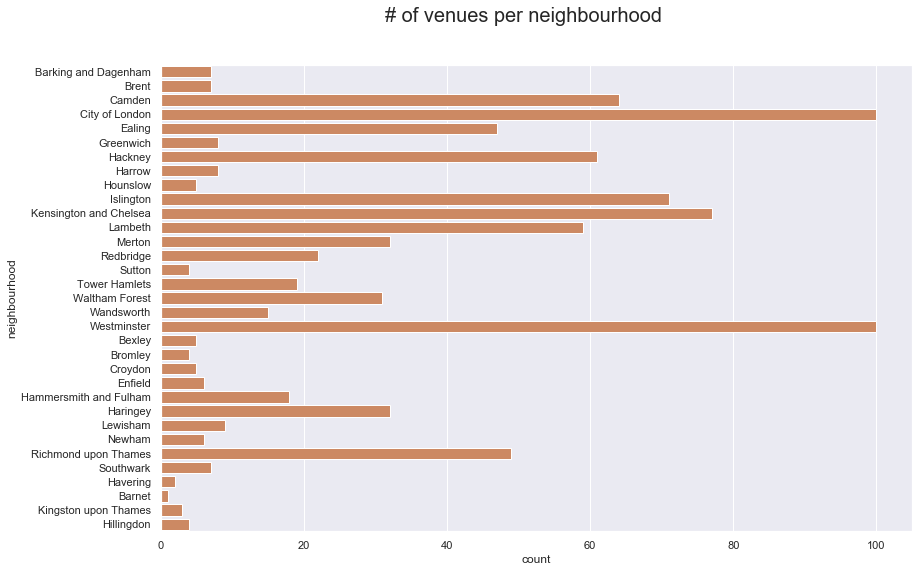

In [421]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))
sns.countplot(data=df_venues_with_cat, y='neighbourhood', color='C1')
plt.suptitle('# of venues per neighbourhood', fontsize=20)
fig.savefig('./img/venues.jpg')

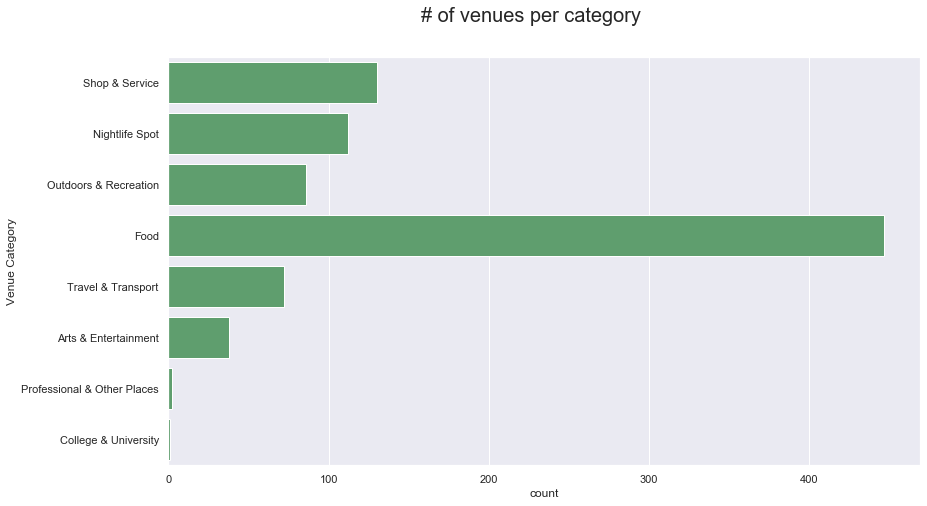

In [468]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
ax = sns.countplot(data=df_venues_with_cat, y='l1_name', color='C2')
ax.set_ylabel('Venue Category')
plt.suptitle('# of venues per category', fontsize=20)
fig.savefig('./img/venues_cat.jpg')

In [467]:
df_venues.shape

(888, 10)

Two things happen next:
1. Tidy up the table and drop unnecessary and redundant columns
2. create distinct columns for all top level categories and their distribution within a neighbourhood and store result in new data frame `df_grouped`

In [279]:
# group data by neighbourhood
drop_columns=[
    'latitude_x', 
    'latitude_y', 
    'longitude_x',
    'longitude_y',
    'geojson',
    'price',
    'Venue Latitude',
    'Venue Longitude',
    'l1_id',
    'l1_name'
    
]
df_grouped = pd.concat([df_venues_with_cat.drop(drop_columns, axis=1), pd.get_dummies(df_venues_with_cat['l1_name'])], axis=1).groupby(['city','neighbourhood']).mean().reset_index()
df_grouped

,city,neighbourhood,airbnb_price_level,Entire home/apt,Hotel room,...,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,london,Barking and Dagenham,-0.279988,0.301075,0.013441,...,0.142857,0.428571,0.00,0.142857,0.000000
1,london,Barnet,-0.156969,0.421338,0.017480,...,0.000000,0.000000,0.00,0.000000,0.000000
2,london,Bexley,-0.270128,0.327138,0.007435,...,0.200000,0.000000,0.00,0.600000,0.000000
3,london,Brent,-0.132493,0.452948,0.012105,...,0.000000,0.000000,0.00,0.142857,0.142857
4,london,Bromley,-0.263086,0.356406,0.055965,...,0.250000,0.500000,0.00,0.250000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
28,london,Sutton,-0.167449,0.300654,0.000000,...,0.000000,0.000000,0.00,0.500000,0.000000
29,london,Tower Hamlets,-0.139105,0.479020,0.013219,...,0.052632,0.263158,0.00,0.157895,0.000000
30,london,Waltham Forest,-0.233569,0.456385,0.003489,...,0.129032,0.032258,0.00,0.225806,0.096774
31,london,Wandsworth,-0.023227,0.561330,0.008895,...,0.200000,0.066667,0.00,0.133333,0.066667


## K-Means clustering

preparing and scaling the data:

In [404]:
grouped_clustering = df_grouped.drop(['city','neighbourhood'], 1)
scaler = StandardScaler()
X_std = scaler.fit_transform(grouped_clustering)

applying the elbow method to calculate optimal k

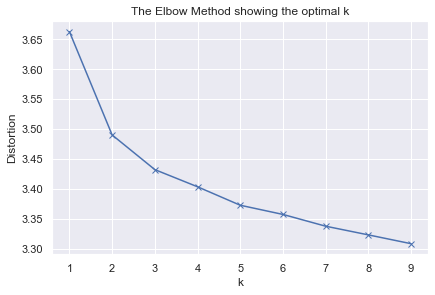

In [405]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_std)
    kmeanModel.fit(grouped_clustering)
    distortions.append(sum(np.min(cdist(X_std, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_std.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow method doesn't yield an unequivocal value of 3 for k, so we take 4 instead:

In [407]:
k = 4
kmeanModel = KMeans(n_clusters=k).fit(X_std)
kmeanModel.labels_

array([2, 3, 1, 1, 2, 3, 0, 2, 3, 2, 1, 3, 3, 3, 1, 1, 1, 3, 3, 0, 2, 3,
       1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 0])

In [408]:
df_grouped['cluster'] = kmeanModel.labels_

In [462]:
def show_nbh_clusters(df_nbh, kclusters=5):
    nbh_mean = np.mean(df_nbh[['latitude', 'longitude']].values, axis=0)
    geojson = df_nbh['geojson'].head(1).values[0]
    
    # setcolorrange
    palette = sns.color_palette()
    hexpalette = [colors.rgb2hex(i) for i in palette]
    city_map =folium.Map(
        location=nbh_mean,
        tiles='CartoDB dark_matter',
        zoom_start=10,
        width=800,
        height=600
    )
    
    def my_color_function(feature):
        """Maps low values to green and hugh values to red."""
        cluster = df_nbh[df_nbh['neighbourhood'] == feature['properties']['neighbourhood']].cluster.max()
        return hexpalette[cluster]
    
     
    folium.GeoJson(
    geojson,
    style_function=lambda x: {'fillColor' : my_color_function(x), 'fillOpacity':0.8, 'color':'black', 'weight':1}
    ).add_to(city_map)

    
    for index, row in df_nbh.iterrows():
        popup_text = "{}, cluster: {}".format(row['neighbourhood'], row['cluster'])
        folium.Circle(
            radius=220,
            location=[row['latitude'], row['longitude']],
            popup=popup_text,
            color=hexpalette[int(row['cluster'])],
            fill_color=hexpalette[int(row['cluster'])],
            fill_opacity=1.0,
            tooltip="{}, cluster: {}".format(row['neighbourhood'], row['cluster']),
            fill=True,
        ).add_to(city_map)
    

    return city_map


In [463]:
show_nbh_clusters(df.merge(df_grouped[df_grouped['city']=='london'], on='neighbourhood'), kclusters=3)

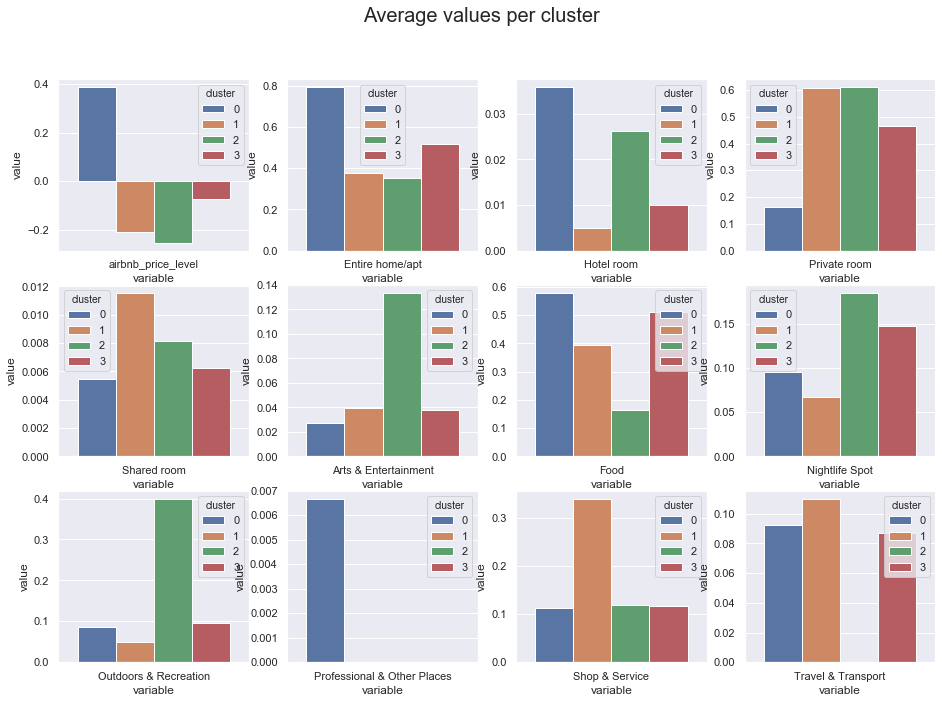

In [472]:
sns.set()
dims = df_grouped.iloc[:,2:-1].columns
dims = dims[dims != 'College & University']
rows = math.ceil(len(dims)/4)
cols = 4
fig, ax = plt.subplots(rows, cols, figsize=(14, 10))
plot_data = df_grouped.groupby('cluster').mean().reset_index().melt(id_vars='cluster')
for i, dim in enumerate(dims, 1):
    plt.subplot(rows, cols, i)
    ax = sns.barplot(data=plot_data[plot_data['variable'] == dim], x='variable', y='value', hue='cluster')
_ =fig.suptitle('Average values per cluster', fontsize=20)
fig.savefig('./img/avg_cluster.jpg')

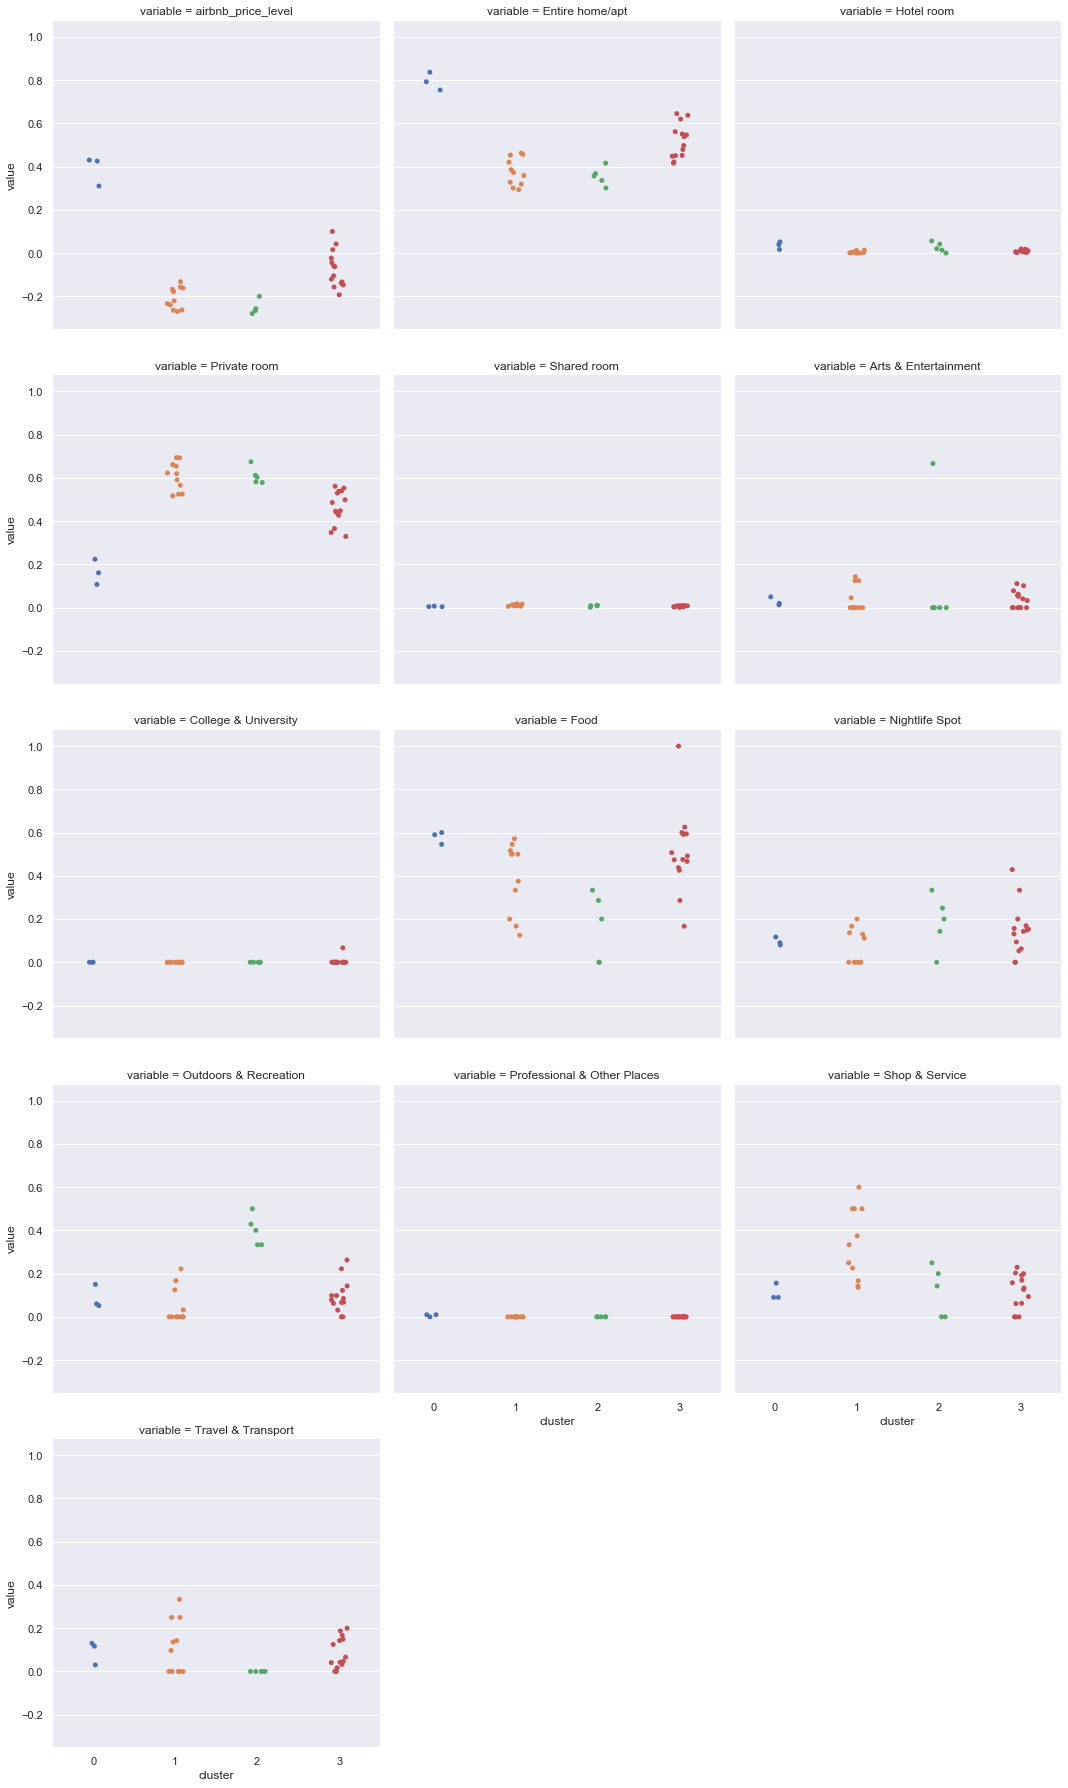

In [413]:
plot_data = df_grouped.melt(id_vars=['city' , 'neighbourhood','cluster'])
g = sns.catplot(x="cluster", y="value", col='variable', col_wrap=3,data=plot_data)